In [37]:
import asdf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'  # we want to show images, not matrices, so we set the origin to the lower-left
plt.matplotlib.style.use('dark_background') 

from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter

# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist


from pathlib import Path

from astropy.nddata import CCDData
import ccdproc
### Block from astropy ccd data reduction guide
from astropy.nddata.blocks import block_reduce
from astropy import visualization as aviz

imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)
### end of that block
# Start with M1

In [2]:
calibrated_data = Path('.', 'reduced_data')
calibrated_data.mkdir(exist_ok=True)
darks = ccdproc.ImageFileCollection('reduced_data/darks/')
m1 = ccdproc.ImageFileCollection('reduced_data/m1/')
m5 = ccdproc.ImageFileCollection('reduced_data/m5/')

In [3]:
linfitter = LinearLSQFitter()
polymodel = Polynomial1D(degree=1)
lmfitter = LevMarLSQFitter()

In [4]:
def trace_extract(image):
    fig, ax = plt.subplots()
    show_image(image, cmap='gray', ax=ax, fig=fig)
    plt.show(block=False)
    image_array = np.array(image)
    min_xtract = int(input("What is the minimum y-axis value to trace?"))
    max_xtract = int(input("What is the maximum y-axis value to trace?"))
    plt.close(fig)
    yaxis = np.repeat(np.arange(min_xtract, max_xtract)[:, None], image.shape[1], axis=1)
    background = np.median(image)
    weighted_yaxis_values = np.average(yaxis, axis=0, 
                                       weights=image_array[min_xtract:max_xtract, :] - background)
    xvals = np.arange(len(weighted_yaxis_values))
    fig, ax = plt.subplots()
    ax.plot(xvals, weighted_yaxis_values, "x")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Moment-1 estimated Y-value trace")
    plt.show(block=False)
    bad_moments = (weighted_yaxis_values < min_xtract) | (weighted_yaxis_values > max_xtract)

    xlims_ornot = input("Do you want to trim out bad x-values? (T/t or F/f)")
    if ((xlims_ornot=='f') | (xlims_ornot=='F') | (xlims_ornot=='n') | (xlims_ornot=='n')):
        fit_polymodel = linfitter(
            polymodel,
            xvals[(~bad_moments)],
            weighted_yaxis_values[(~bad_moments)])
    else:
        min_bad = int(input("What is the x-axis value below which to throw out?"))
        fit_polymodel = linfitter(
            polymodel,
            xvals[(~bad_moments) & (xvals > min_bad)],
            weighted_yaxis_values[(~bad_moments) & (xvals > min_bad)])
    plt.close(fig)
    while True:
        cutout = int(input("How many pixels should we cut"))

        fig, ax = plt.subplots()
        ax.imshow(image_array[min_xtract:max_xtract, :], extent=[0, image_array.shape[1], min_xtract, max_xtract])
        ax.set_aspect(10)
        ax.fill_between(
            xvals,
            fit_polymodel(xvals) - cutout,
            fit_polymodel(xvals) + cutout,
            color="orange",
            alpha=0.2,
        )
        plt.show(block=False)
        good = input('Is this appropriate number of pixels to fill? (Y/y, N/n)')
        if ((good =='Y') | (good=='y')):
            plt.close(fig)
            break
        else:
            plt.close(fig)

    trace_center = fit_polymodel(xvals[~bad_moments])

    cut = np.array([image_array[int(yval)-cutout:int(yval)+cutout, ii]
                         for yval, ii in zip(trace_center, xvals[~bad_moments])])
    mean_trace_profile = (cut - background).mean(axis=0)
    trace_profile_xaxis = np.arange(-cutout, cutout)
    guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
    fitted_trace_profile = lmfitter(
        model=guess, x=trace_profile_xaxis, y=mean_trace_profile
    )
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    trace_avg_spectrum = np.array(
    [
        np.average(
            image_array[int(yval) - cutout : int(yval) + cutout, ii]
            - background,
            weights=mean_trace_profile,
        )
        for yval, ii in zip(trace_center, xvals[~bad_moments])
    ])
    gaussian_trace_avg_spectrum = np.array(
    [
        np.average(
            image_array[int(yval) - cutout : int(yval) + cutout, ii]
            - background,
            weights=model_trace_profile,
        )
        for yval, ii in zip(trace_center, xvals[~bad_moments])
    ])
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(trace_profile_xaxis, mean_trace_profile, label="data")
    ax1.plot(trace_profile_xaxis, model_trace_profile, label="model")
    ax1.legend(loc="best")
    ax1.set_xlabel("Distance from center")
    ax1.set_ylabel("Average source profile")    
    ax2.plot(trace_avg_spectrum, label="Trace-weighted average")
    ax2.plot(
        gaussian_trace_avg_spectrum,
        label="Gaussian-model",
        alpha=0.5,
        linewidth=0.5,
        color="r",
    )
    ax2.legend(loc="best")
    plt.show(block=False)
    plt.close()
    return fit_polymodel, model_trace_profile, cutout, gaussian_trace_avg_spectrum, bad_moments

In [5]:
m5

ImageFileCollection(location='reduced_data/m5/')

In [6]:
m1 = m1.files_filtered(include_path=True)
m5 = m5.files_filtered(include_path=True)

science_m1 = CCDData.read(m1[0], unit='adu')
science_m5 = CCDData.read(m5[0], unit='adu')

lamp_m1 = CCDData.read(m1[1])
lamp_m5 = CCDData.read(m5[1])

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


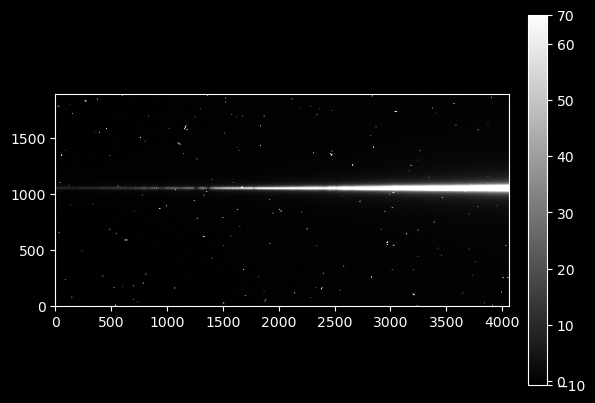

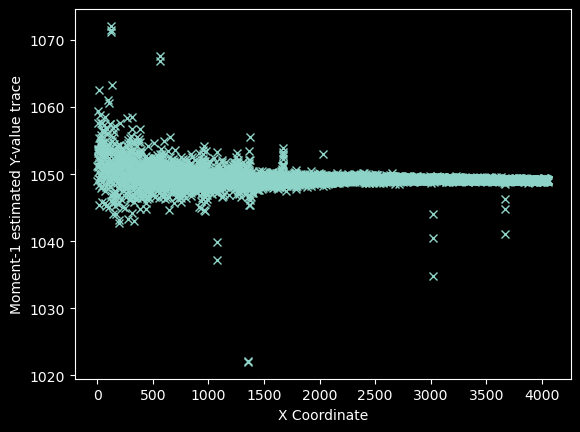

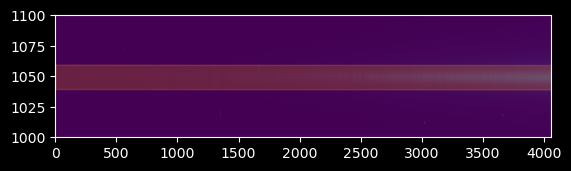

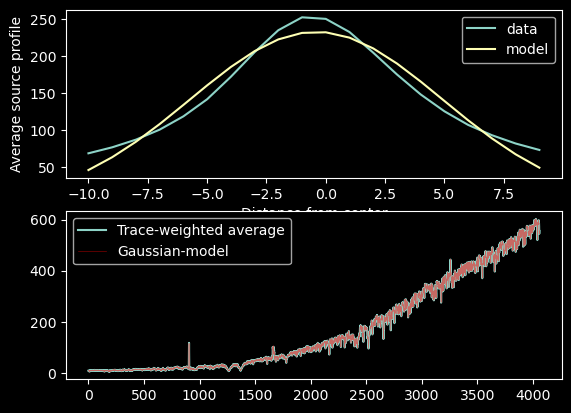

In [7]:
fitted_polymodel_m1, model_trace_profile_m1, ncut_m1, spec_m1, badmom_m1 = trace_extract(science_m1)

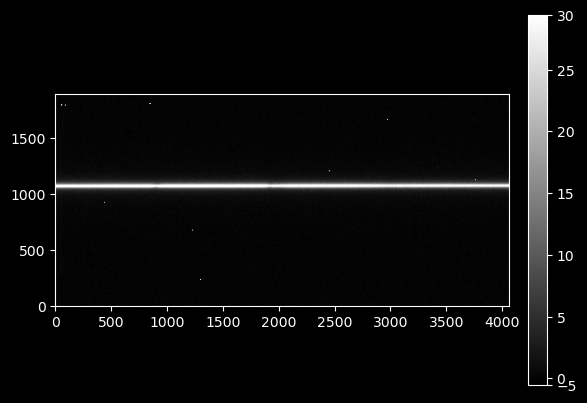

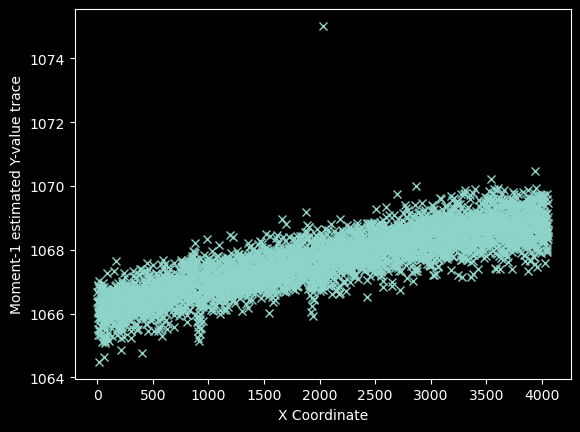

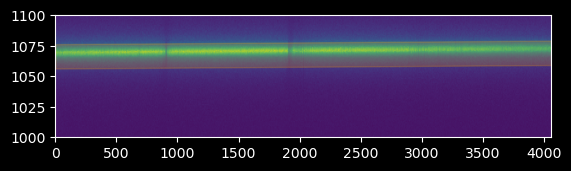

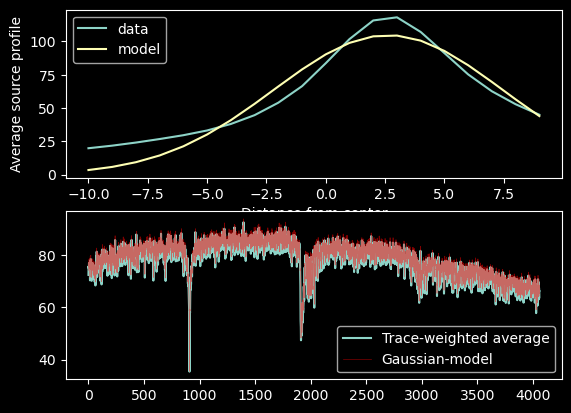

In [8]:
fitted_polymodel_m5, model_trace_profile_m5, ncut_m5, spec_m5, badmom_m5 = trace_extract(science_m5)

In [9]:
wlmodel = Linear1D()

In [10]:
import matplotlib 
matplotlib.use('macosx') # Or 'QtAgg', 'Agg', etc.


In [11]:
def collect_wl_guesses(lamp, lin_model, traced_profile, ncut):
    xvals = np.arange(lamp.shape[1])
    trace = lin_model(xvals)
    data = lamp.data
    image_array = np.array(data)
    background = np.median(data)
    lamp_spectrum = np.array(
        [
            np.average(
                image_array[int(yval) - ncut : int(yval) + ncut, ii]
               - background,
                weights=traced_profile,
            )
            for yval, ii in zip(trace, xvals)
        ]
    )
    npixels = 20
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(xvals, lamp_spectrum+100)
    plt.show(block=True)
    improved_xval_guesses_ne = None
    improved_xval_guesses_ar = None

    alines = int(input('How many Argon lines are you guessing?'))
    lister = list(map(int, (input('Input a list of integer pixel values for the Argon lines').split())))

    argon_pix_guesses = [int(val) for val in lister]
    lister2 = list(map(float, (input('Input a list of float WL v values for the Argon lines').split())))

    argon_wl_guesses = [int(val) for val in lister2]

    nline = int(input('How many Neon lines are you guessing?'))
    lister3 = list(map(int, (input('Input a list of integer pixel values for the Neon lines').split())))
    neon_pix_guesses = [int(val) for val in lister3]
    lister4 = list(map(float, (input('Input a list of float WL v values for the Neon lines').split())))
    neon_wl_guesses = [int(val) for val in lister4]

    improved_xval_guesses_ar = [
        np.average(
            xvals[g - npixels : g + npixels],
            weights=lamp_spectrum[g - npixels : g + npixels] - np.median(lamp_spectrum),
        )
        for g in argon_pix_guesses
    ]
    if nline==0:
        print('hi')
    else:
        improved_xval_guesses_ne = [
            np.average(
                xvals[g - npixels : g + npixels],
                weights=lamp_spectrum[g - npixels : g + npixels] - np.median(lamp_spectrum),
            )
            for g in neon_pix_guesses
        ]
    plt.close()
    fig, ax = plt.subplots()
    ax.plot(xvals, lamp_spectrum)
    if (improved_xval_guesses_ne!=None):
        if (nline==0):
            print('hi')
        elif(nline!=0):  
            ax.plot(improved_xval_guesses_ne, [np.max(lamp_spectrum)-2000] * len(improved_xval_guesses_ne), "+", label='Improved Neon')
    if improved_xval_guesses_ar!=None:
        ax.plot(improved_xval_guesses_ar, [np.max(lamp_spectrum)-2000]  * len(improved_xval_guesses_ar), "+", label='Improved Argon')
    plt.legend()    
    plt.show(block=False)    
    return improved_xval_guesses_ar, argon_wl_guesses, improved_xval_guesses_ne, neon_wl_guesses

In [12]:
xvals = np.arange(lamp_m1.shape[1])

pix = 392 1611 2566
wl: 3948.979 4044.418 4200.67

In [13]:
arguess_m1pix, arguess_m1wl, neguess_m1pix, neguess_m1wl = collect_wl_guesses(lamp_m1, fitted_polymodel_m1, model_trace_profile_m1, ncut_m1)

hi


arpix = 2233 3260 3650
arwls = 6965.4310 7272.9360 7383.99

nepix = 323 384 728 814 2456
newls = 6382.9917 6402.2480 6506.5281 6532.8822 7032.4131

In [14]:
arguess_m5pix, arguess_m5wl, neguess_m5pix, neguess_m5wl = collect_wl_guesses(lamp_m5, fitted_polymodel_m5, model_trace_profile_m5, ncut_m5)

In [15]:
xvals_m1 = np.concatenate([arguess_m1pix])
wls_m1 = np.concatenate([arguess_m1wl])
wlmodel_m1 = linfitter(
    model=wlmodel, x=xvals_m1, y=wls_m1
)
wavelengths_m1 = wlmodel_m1(xvals) * u.AA


xvals_m5 = np.concatenate([arguess_m5pix, neguess_m5pix])
wls_m5 = np.concatenate([arguess_m5wl, neguess_m5wl])
wlmodel_m5 = linfitter(
    model=wlmodel, x=xvals_m5, y=wls_m5
)
wavelengths_m5 = wlmodel_m5(xvals) * u.AA

In [16]:
def do_nist(wl_model, lamp, trace_mod, traced_profile, ncut, guesses, argon=True, neon=False, m1=False):
    xvals = np.arange(lamp.shape[1])
    wavelengths = wl_model(xvals)*u.AA
    trace = trace_mod(xvals)
    data = lamp.data
    image_array = np.array(data)
    background = np.median(data)
    lamp_spectrum = np.array(
        [
            np.average(
                image_array[int(yval) - ncut : int(yval) + ncut, ii]
               - background,
                weights=traced_profile,
            )
            for yval, ii in zip(trace, xvals)
        ]
    )
    # we adopt the minimum/maximum wavelength from our linear fit
    minwave = wavelengths.min()
    maxwave = wavelengths.max()
    npixels=10
    if argon==True:
        argon_lines = Nist.query(minwav=minwave, maxwav=maxwave, linename="Ar I")
        ar_keep = (~argon_lines["Rel."].mask) & (argon_lines["Rel."] != "*")
        ar_wl_tbl = argon_lines["Observed"][ar_keep]
        ar_rel_tbl = np.array([float(x) for x in argon_lines["Rel."][ar_keep]])
        ar_rel_intens = ar_rel_tbl / ar_rel_tbl.max() * lamp_spectrum.max()
        if m1==True:
            ar_keep_final = ar_rel_intens > 1000
        else:
            ar_keep_final = ar_rel_intens > 20000
        ar_wl_final = ar_wl_tbl[ar_keep_final]
        ar_pixel_vals = wl_model.inverse(ar_wl_final)
        nist_xval_guesses_ar = [
            np.average(
                xvals[g - npixels : g + npixels],
                weights=lamp_spectrum[g - npixels : g + npixels] - np.median(lamp_spectrum),
            )
            for g in map(int, ar_pixel_vals)
        ]

    if neon==True:
        neon_lines = Nist.query(minwav=minwave, maxwav=maxwave, linename="Ne I")
        ne_keep = (~neon_lines["Rel."].mask) & (neon_lines["Rel."] != "*")
        ne_wl_tbl = neon_lines["Observed"][ne_keep]
        ne_rel_tbl = np.array([float(x) for x in neon_lines["Rel."][ne_keep]])
        ne_rel_intens = ne_rel_tbl / ne_rel_tbl.max() * lamp_spectrum.max()
        ne_keep_final = ne_rel_intens > 20000
        ne_wl_final = ne_wl_tbl[ne_keep_final]
        ne_pixel_vals = wl_model.inverse(ne_wl_final)
        nist_xval_guesses_ne = [
            np.average(
                xvals[g - npixels : g + npixels],
                weights=lamp_spectrum[g - npixels : g + npixels] - np.median(lamp_spectrum),
            )
            for g in map(int, ne_pixel_vals)
        ]
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(xvals, lamp_spectrum)
    if neon==True:
        ax1.plot(ne_pixel_vals, ne_rel_intens[ne_keep_final], "x", label='neon')
        ax2.plot(guesses[2], guesses[3], "x", label="Guesses (Ne)")
        ax2.plot(nist_xval_guesses_ne, ne_wl_final, "+", label="Fit to NIST (Ne)")
    ax1.plot(ar_pixel_vals, ar_rel_intens[ar_keep_final], "x", label='argon')
    ax1.legend()
    
    ax2.plot(guesses[0], guesses[1], "x", label="Guesses (Ar)")
    ax2.plot(nist_xval_guesses_ar, ar_wl_final, "+", label="Fit to NIST (Ar)")
    ax2.plot(xvals, wavelengths)
    ax2.legend(loc="best")
    ax2.set_xlabel("Pixel Coordinate")
    ax2.set_ylabel("Wavelength (nm)")
    plt.show()    
    if neon==True:
        xvals_nist = np.concatenate([nist_xval_guesses_ar, nist_xval_guesses_ne])
        waves_nist = np.concatenate([list(ar_wl_final), list(ne_wl_final)])
    else:
        xvals_nist = np.concatenate([nist_xval_guesses_ar])
        waves_nist = np.concatenate([list(ar_wl_final)])
    linfit_combined_model = linfitter(model=wlmodel, x=xvals_nist, y=waves_nist)
    print(f'New solution is {linfit_combined_model}\n\n\nOld solution was {wl_model}')
    return linfit_combined_model

In [17]:
plt.ioff()
%matplotlib inline

In [18]:
m5_guesses = [arguess_m5pix, arguess_m5wl, neguess_m5pix, neguess_m5wl]

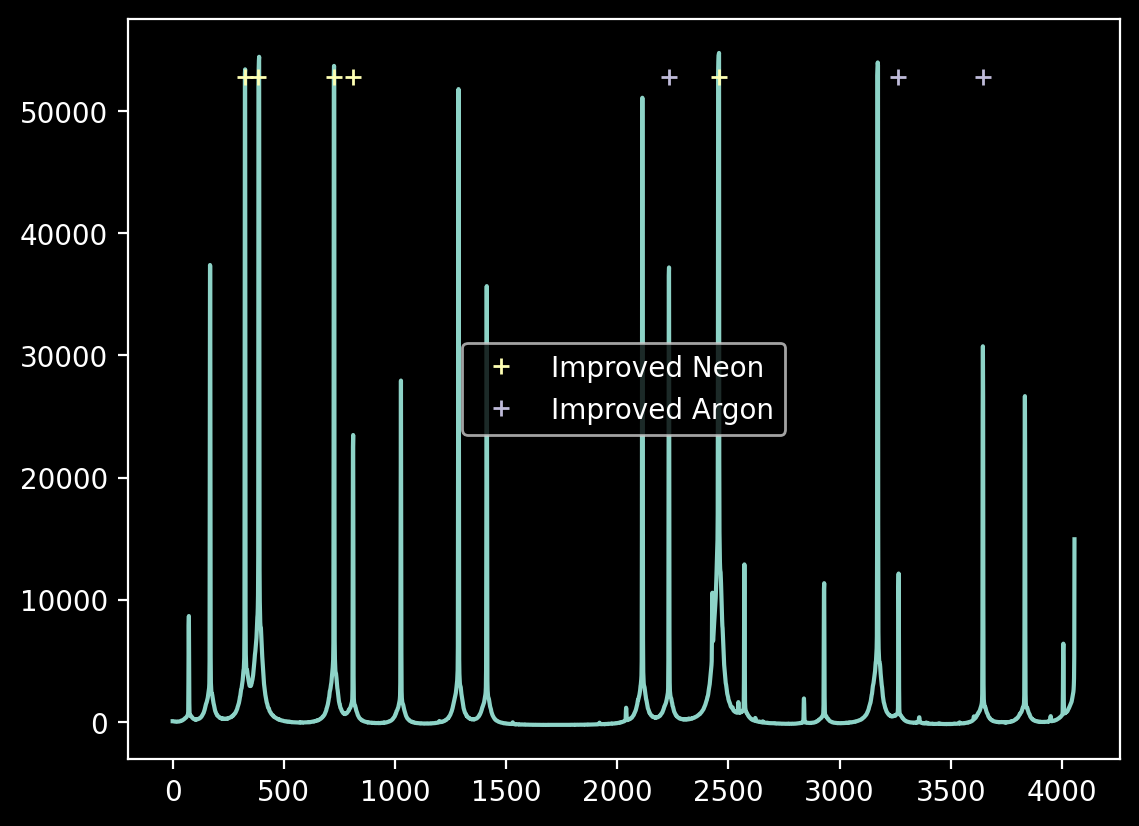

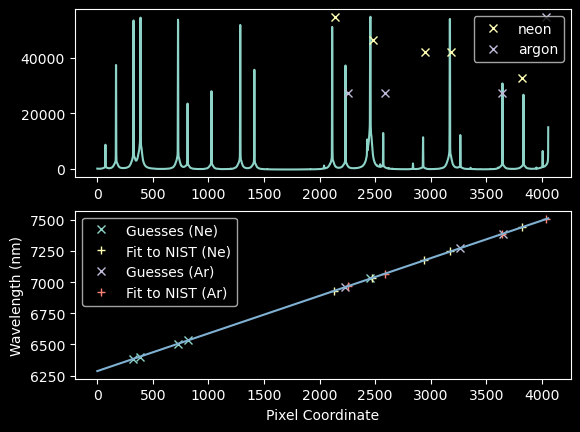

New solution is Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept    
    ------------------- -----------------
    0.30122527858448117 6289.565143467628


Old solution was Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    0.3020456276907339 6286.449983618471


In [19]:
wl_calib_model_m5 = do_nist(wlmodel_m5, lamp_m5, fitted_polymodel_m5, model_trace_profile_m5, ncut_m5, m5_guesses, True, True)

In [20]:
m1_guesses = [arguess_m1pix, arguess_m1wl]

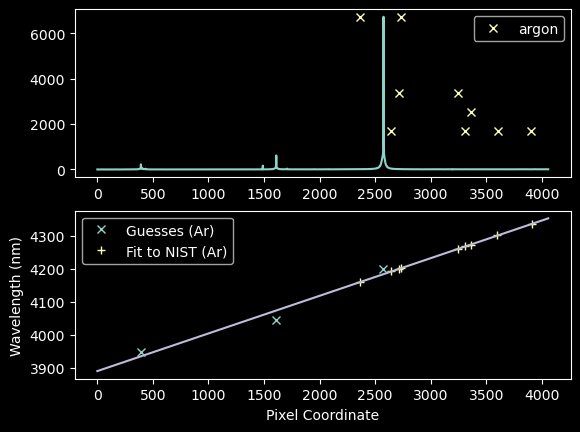

New solution is Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept     
    ------------------- ------------------
    0.11371935108646544 3891.1692650216187


Old solution was Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept     
    ------------------- ------------------
    0.11402567711075907 3890.1152442095577


In [21]:
wl_calib_model_m1 = do_nist(wlmodel_m1, lamp_m1, fitted_polymodel_m1, model_trace_profile_m1, ncut_m1, m1_guesses, True, False, True)

[Text(0.5, 1.0, 'Science Image (WL solution)'),
 Text(0.5, 1.0, 'Science Image (WL solution)')]

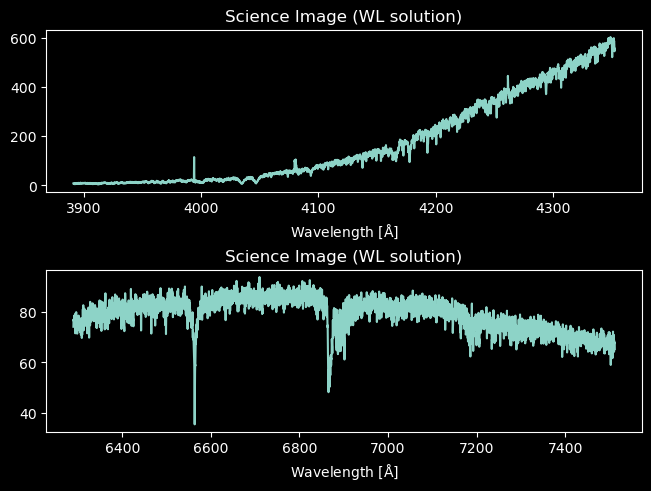

In [27]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout='constrained')
ax1.plot(wl_calib_model_m1(xvals[~badmom_m1]), spec_m1)
ax2.plot(wl_calib_model_m5(xvals[~badmom_m5]), spec_m5)

[ax.set_xlabel(r"Wavelength [$\rm{\AA}$]") for ax in [ax1, ax2]]
[ax.set_title("Science Image (WL solution)") for ax in [ax1, ax2]]

In [ ]:
M1_tree = {'m1_model': wl_calib_model_m1}
with asdf.AsdfFile(M1_tree) as ff:
    ff.write_to("analysis/m1_model.asdf")

M5_tree = {'m5_model': wl_calib_model_m5}
with asdf.AsdfFile(M5_tree) as ff:
    ff.write_to("analysis/m5_model.asdf")

#with asdf.open("analysis/m5_model.asdf") as ff:
#    loaded_model = ff['m5_model']

In [36]:
np.save("analysis/m1_spectra.npy", spec_m1)
np.save("analysis/m5_spectra.npy", spec_m5)

#m1_spec = np.load("analysis/m1_spectra.npy")